# Рекомендация активного тарифа для пользователей архивных тарифов

В моем распоряжении данные о поведении клиентов, которые уже перешли с архивных тарифов на действующие. Используя эти данные, необходимо построить модель, которая предложит наиболее подходящий тариф для пользователей архивных тарифов. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier

## Изучение и ознакомление с данными

In [2]:
users = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP5\\users_behavior.csv')

In [3]:
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
users.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Данные предобработаны: пропусков нет, формат данных готов к работе.
Посмотрим на корреляцию и распределение данных по тарифам, чтобы посмотреть структуру данных.

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


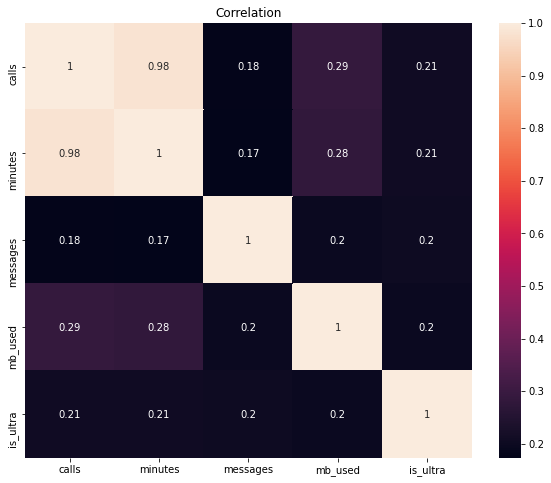

In [6]:
display(users.corr())
plt.figure(figsize=(10, 8))
plot = sns.heatmap(users.corr(), annot=True)
plot.set_title('Correlation')
print()

Очень высокая корреляция между minutes и calls, исключу из датасета колонку calls, чтобы минимизировать переобучение.

In [7]:
users = users.drop('calls', axis=1)
users.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


In [8]:
# Создаю временную колонку, чтобы в графике отображалось название тарифа
users['tariff_name'] = users['is_ultra'].replace([0,1], ['Smart','Ultra'])

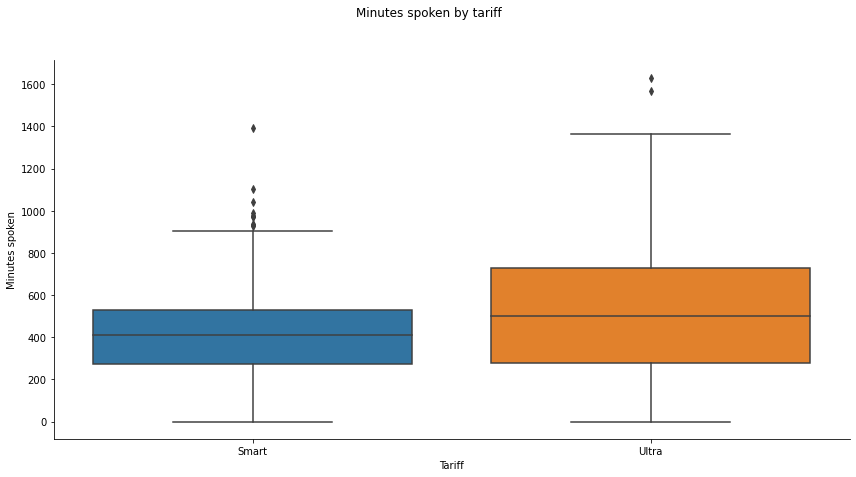

In [9]:
plot = sns.catplot(data=users, x='tariff_name', y='minutes', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Tariff', y_var='Minutes spoken')
plot.set
plot.fig.suptitle('Minutes spoken by tariff', y=1.1);

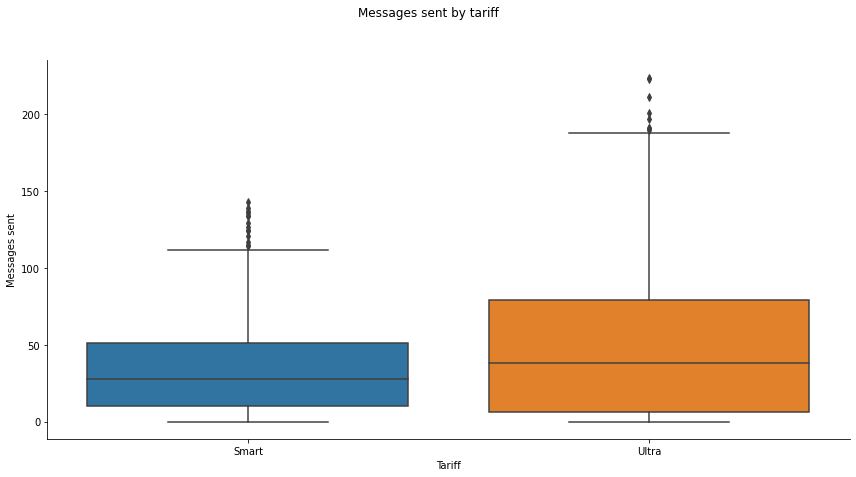

In [10]:
plot = sns.catplot(data=users, x='tariff_name', y='messages', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Tariff', y_var='Messages sent')
plot.set
plot.fig.suptitle('Messages sent by tariff', y=1.1);

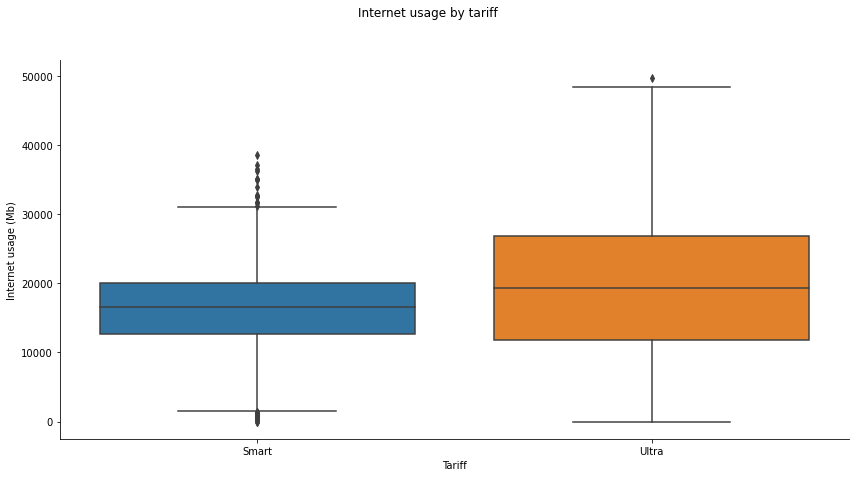

In [11]:
plot = sns.catplot(data=users, x='tariff_name', y='mb_used', kind='box', height=6, 
                    aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Tariff', y_var='Internet usage (Mb)')
plot.set
plot.fig.suptitle('Internet usage by tariff', y=1.1);

Из графиков видно, что пользователи тарифа Ultra используют больше минут, сообщений и интернет трафика.

In [12]:
#Удаляю временную колонку
users = users.drop('tariff_name', axis=1)

## Разделение данных

Разобью датасет на 2 датасета: 1ый с параметрами, по которым предсказываем, 2ой с предсказываемым параметром

In [13]:
x_users = users.drop('is_ultra', axis=1)
y_users = users['is_ultra']

In [14]:
users['is_ultra'].value_counts() / users.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Разделю датасеты на обучающую и тестовую выборку (бью на две части вместо трех, тк в дальнейшем планирую подбор параметров с помощью кроссвалидации). Пропорции между тарифами дисбалансированы (70/30), поэтому использую stratify, чтобы сохранить пропорции.

In [15]:
x_users_train, x_users_test, y_users_train, y_users_test = train_test_split(x_users, y_users, test_size=0.25, 
                                                                            random_state = 0, stratify=users['is_ultra'])

In [16]:
x_users_train.shape, x_users_test.shape, y_users_train.shape, y_users_test.shape

((2410, 3), (804, 3), (2410,), (804,))

## Тестирование моделей: 1) DecisionTree

In [17]:
dt_clf = DecisionTreeClassifier(random_state=0)

Выбираю параметры для перебора:

In [18]:
params = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,20),
          'min_samples_leaf' : range(1,20,5), 'class_weight' : [None, 'balanced']}

In [19]:
dt_clf_grid_search = GridSearchCV(dt_clf, params, cv=5, verbose=1)

In [20]:
dt_clf_grid_search.fit(x_users_train, y_users_train)

Fitting 5 folds for each of 304 candidates, totalling 1520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:   13.5s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 20, 5)},
             verbose=1)

Сохраняю наилучшие параметры:

In [21]:
dt_best_clf = dt_clf_grid_search.best_estimator_
dt_best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=16,
                       random_state=0)

In [22]:
dt_best_train_score = dt_best_clf.score(x_users_train, y_users_train)
print(f'Accuracy на кросс-валидационной выборке: {dt_best_train_score}')

Accuracy на кросс-валидационной выборке: 0.8141078838174274


In [23]:
print('Метрики Precision, Recall, F-Score по кросс-валлидационной выборке')
display(pd.DataFrame(precision_recall_fscore_support(y_users_train, dt_best_clf.predict(x_users_train)))
.rename(columns={0 : 'Smart', 1: 'Ultra'}, index={ 0 : 'Precision', 1 : 'Recall', 2 : 'F-Score', 3 : 'Samples'}))

Метрики Precision, Recall, F-Score по кросс-валлидационной выборке


,Smart,Ultra
Precision,0.813429,0.816993
Recall,0.949731,0.507442
F-Score,0.876311,0.626043
Samples,1671.000000,739.000000


Сильно выделятся параметр полноты по предсказаниям тарифа Ultra, удается его классифицировать только в половине случаев.

## Тестирование моделей: 2) RandomForest

In [24]:
rf_clf = RandomForestClassifier(random_state=0)

Выбираю параметры для перебора:

In [25]:
params = {'max_depth' : range(1,20,2), 'min_samples_leaf' : range(1,20,5), 'n_estimators' : range(1,20,2)}

In [26]:
rf_clf_grid_search = GridSearchCV(rf_clf, params, cv=5, verbose=1)

In [27]:
rf_clf_grid_search.fit(x_users_train, y_users_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   50.5s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(1, 20, 2),
                         'min_samples_leaf': range(1, 20, 5),
                         'n_estimators': range(1, 20, 2)},
             verbose=1)

Сохраняю наилучшие параметры:

In [28]:
rf_best_clf = rf_clf_grid_search.best_estimator_
rf_best_clf

RandomForestClassifier(max_depth=11, min_samples_leaf=11, n_estimators=9,
                       random_state=0)

In [29]:
rf_best_train_score = rf_best_clf.score(x_users_train, y_users_train)
print(f'Accuracy на кросс-валидационной выборке: {rf_best_train_score}')

Accuracy на кросс-валидационной выборке: 0.8257261410788381


In [30]:
print('Метрики Precision, Recall, F-Score по предсказаниям на кросс-валидационной выборке')
display(pd.DataFrame(precision_recall_fscore_support(y_users_train, rf_best_clf.predict(x_users_train)))
.rename(columns={0 : 'Smart', 1: 'Ultra'}, index={ 0 : 'Precision', 1 : 'Recall', 2 : 'F-Score', 3 : 'Samples'}))

Метрики Precision, Recall, F-Score по предсказаниям на кросс-валидационной выборке


,Smart,Ultra
Precision,0.83183,0.803810
Recall,0.93836,0.571042
F-Score,0.88189,0.667722
Samples,1671.00000,739.000000


Также выделятся параметр полноты по предсказаниям тарифа Ultra, но лучше, чем в случае с DecisionTree.

## Тестирование моделей: 3) LogisticRegression

In [31]:
lr_clf = LogisticRegression(random_state=0)

In [32]:
lr_clf.fit(x_users_train, y_users_train)

LogisticRegression(random_state=0)

In [33]:
lr_best_train_score = lr_clf.score(x_users_train, y_users_train)
print(f'Accuracy на обучающей выборке: {lr_best_train_score}')

Accuracy на обучающей выборке: 0.7107883817427386


In [34]:
print('Метрики Precision, Recall, F-Score по предсказаниям на обучающей выборке')
display(pd.DataFrame(precision_recall_fscore_support(y_users_train, lr_clf.predict(x_users_train)))
.rename(columns={0 : 'Smart', 1: 'Ultra'}, index={ 0 : 'Precision', 1 : 'Recall', 2 : 'F-Score', 3 : 'Samples'}))

Метрики Precision, Recall, F-Score по предсказаниям на обучающей выборке


,Smart,Ultra
Precision,0.708655,0.776316
Recall,0.989826,0.079838
F-Score,0.825968,0.144785
Samples,1671.000000,739.000000


## Тестирование моделей: Сводная информация и вывод

In [35]:
results = pd.DataFrame({'Model' : ['DecisionTree', 'RandomForest','LogisticRegression'], 
                       'Train Accuracy' : [dt_best_train_score, rf_best_train_score, lr_best_train_score],
                       'Test Accuracy' : [dt_best_clf.score(x_users_test, y_users_test), 
                                          rf_best_clf.score(x_users_test, y_users_test), 
                                          lr_clf.score(x_users_test, y_users_test)]})

In [36]:
print('Accuracy обучающих и тестовых выборок в разрезе моделей')
display(results.sort_values(by='Test Accuracy', ascending=False))

Accuracy обучающих и тестовых выборок в разрезе моделей


,Model,Train Accuracy,Test Accuracy
1,RandomForest,0.825726,0.800995
0,DecisionTree,0.814108,0.797264
2,LogisticRegression,0.710788,0.711443


In [37]:
feature_importances = pd.DataFrame({'features':list(x_users_train.columns), 
                                       'feature_importances':  rf_best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending=False)
print('Влияние признаков на результат предсказания')
display(feature_importances)

Влияние признаков на результат предсказания


,features,feature_importances
2,mb_used,0.429953
0,minutes,0.307783
1,messages,0.262265


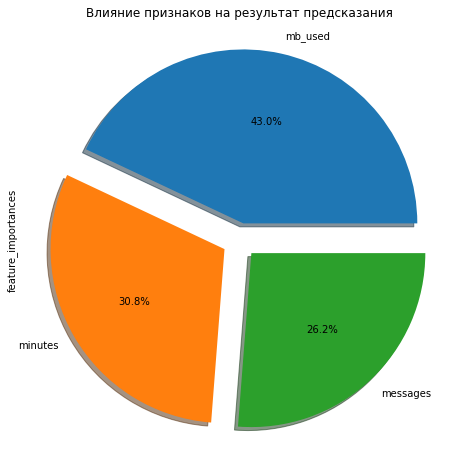

In [38]:
feature_importances.plot.pie(explode=[0.1]*len(x_users_train.columns),labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(8, 8), 
                             title='Влияние признаков на результат предсказания');

Наилучшим образом показала себя модель RandomForest с долей правильных ответов 80%. 
Лучшими параметрами являются: 
- criterion = 'gini'
- n_estimators = 9
- max_depth = 11
- min_samples_split = 2
- min_samples_leaf = 11 

Признак 'mb_used' является наиболее влиящим на предсказанный результат (вес 0,43), далее следует 'minutes' (вес 0,31) и затем 'messages' (с весом 0,26).

Наихудший результат у логистической регрессии: 71%. 

То есть если мы просто выберем для предсказания наиболее встречаемый тариф ('Smart') и для всех случаев в тестовой выборке "предскажем" 0 ('Smart'), результат доли правильных ответов будет такой же: 70%.

## Проверка модели на адекватность

In [39]:
dummy_clf = DummyClassifier(random_state=0)

Выбираю параметры для перебора:

In [40]:
params = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

In [41]:
dummy_clf_grid_search = GridSearchCV(dummy_clf, params, cv=5, verbose=1)

In [42]:
dummy_clf_grid_search.fit(x_users_train, y_users_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


GridSearchCV(cv=5, estimator=DummyClassifier(random_state=0),
             param_grid={'strategy': ['stratified', 'most_frequent', 'prior',
                                      'uniform']},
             verbose=1)

Сохраняю наилучшую стратегию:

In [43]:
dummy_best_clf = dummy_clf_grid_search.best_estimator_
dummy_best_clf

DummyClassifier(random_state=0, strategy='most_frequent')

In [44]:
dummy_best_train_score = dummy_best_clf.score(x_users_train, y_users_train)
dummy_best_test_score = dummy_best_clf.score(x_users_test, y_users_test)
print(f'Accuracy на обучающей выборке: {dummy_best_train_score}')
print(f'Accuracy на тестовой выборке: {dummy_best_test_score}')

Accuracy на обучающей выборке: 0.6933609958506224
Accuracy на тестовой выборке: 0.6940298507462687


In [45]:
results.loc[3] = (['Dummy', dummy_best_train_score, dummy_best_test_score])
print('Accuracy обучающих и тестовых выборок в разрезе моделей')
display(results.sort_values(by='Test Accuracy', ascending=False))

Accuracy обучающих и тестовых выборок в разрезе моделей


,Model,Train Accuracy,Test Accuracy
1,RandomForest,0.825726,0.800995
0,DecisionTree,0.814108,0.797264
2,LogisticRegression,0.710788,0.711443
3,Dummy,0.693361,0.694030


Если мы просто выберем для предсказания наиболее встречаемый тариф ('Smart') и для всех случаев в тестовой выборке "предскажем" 0 ('Smart'), результат доли правильных ответов будет: 69%. Подобранная модель RandomForest дала более высокий результат: 80%. Так как часть неопределенности в предсказаниях с помощью RandomForest получилось убрать, рискну предположить, что модель адекватная и имеет право на существование.

## Вывод

В процессе изучения предоставленных данных были обнаружены 2 признака с корреляцией 0,98 ('minutes' и 'calls'), признак 'calls' был исключен, так как он не имеет дополнительной ценности для модели (достаточно одной). Были протестированы 3 модели: DecisionTree, RandomForest и LogisticRegression, в каждой из которых были подобраны оптимальные параметры. 

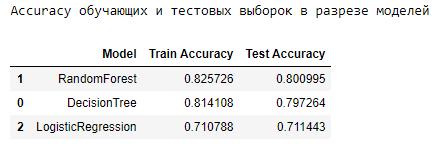

Наилучшим образом показала себя модель RandomForest с долей правильных ответов 80%. 
Оптимальные параметры для модели: 
- criterion = 'gini'
- n_estimators = 9
- max_depth = 11
- min_samples_split = 2
- min_samples_leaf = 11 

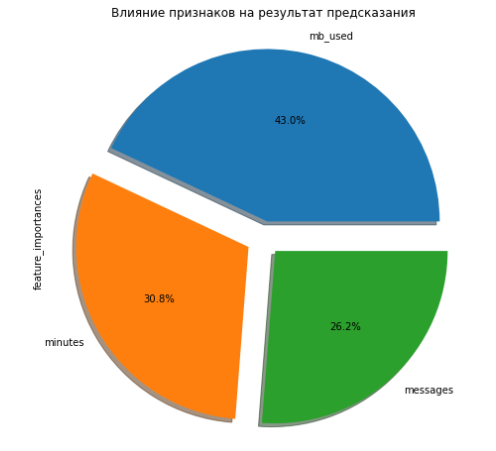

Признак 'mb_used' является наиболее влиящим на предсказанный результат (вес 0,43), далее следует 'minutes' (вес 0,31) и затем 'messages' (с весом 0,26).

Наихудший результат у логистической регрессии: 71%. 

Также была предпринята попытка проверить модель на адекватность: 

Если мы просто выберем для предсказания наиболее встречаемый тариф ('Smart') и для всех случаев в тестовой выборке "предскажем" 0 ('Smart'), результат доли правильных ответов будет: 69%. Подобранная модель RandomForest дала более высокий результат: 80%. Так как часть неопределенности в предсказаниях с помощью RandomForest получилось убрать, рискну предположить, что модель адекватная и имеет право на существование.